This notebook explores biomedical text mining. We will use PubMed e-utilities to search and download recent publications about COVID-19 from PubMed. We will then use PubTator to retrieve several types of named entities from these abstracts and visualize them in several ways to better understand the content of these publications. 

In [2]:
# install these packages if needed
!pip install unidecode
!pip install xmltodict

  Obtaining dependency information for unidecode from https://files.pythonhosted.org/packages/e4/63/7685ef40c65aba621ccd2524a24181bf11f0535ab1fdba47e40738eacff6/Unidecode-1.3.7-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.5 MB/s eta 0:00:00a 0:00:01


In [3]:
import pandas as pd
import requests
import io
import sys
import re
import os
import time
from unidecode import unidecode
import xml.etree.ElementTree as ET
import json
import time
import matplotlib.pyplot as plt
import xmltodict

We will first use e-utilities API **ESearch** function to search for COVID-19 publications in PubMed. Esearch retuns publication identifiers (PMIDs). 

In [4]:
# the base URL for PubMed esearch
url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed"

# search string for Covid19
# ("coronavirus"[All Fields] OR "ncov"[All Fields] OR "cov"[All Fields] OR "2019-nCoV"[All Fields] 
# OR "SARS-CoV-2"[All Fields]) OR "COVID19"[All Fields] OR "COVID-19"[All Fields] OR "COVID"[All Fields]) 
# AND ("2000/01/01"[CRDT] : "3000/01/01"[CRDT])
# This will return 1000 most recent articles on COVID-19 (defined in terms of the search string above) to current time. 
search_query = '&term=("coronavirus"[All Fields] OR "ncov"[All Fields] OR "cov"[All Fields] OR "2019-nCoV"[All Fields] OR "SARS-CoV-2"[All Fields]) OR "COVID19"[All Fields] OR "COVID-19"[All Fields] OR "COVID"[All Fields]) AND ("2000/01/01"[CRDT] : "3000/01/01"[CRDT])&retmax=1000'

# send request and receive response
response = []
r = requests.post(url+search_query)
if r.status_code != 200 :
    print ("[Error]: HTTP code "+ str(r.status_code))
else:
    response = r.text

# print returned response 
print(response)

# save the response which includes PMIDs to XML file for later use
with open("covid_pmid_list.xml", 'w', encoding='utf8') as outputfile:
    outputfile.write(response)
outputfile.close()


<?xml version="1.0" encoding="UTF-8" ?>
<!DOCTYPE eSearchResult PUBLIC "-//NLM//DTD esearch 20060628//EN" "https://eutils.ncbi.nlm.nih.gov/eutils/dtd/20060628/esearch.dtd">
<eSearchResult><Count>412150</Count><RetMax>1000</RetMax><RetStart>0</RetStart><IdList>
<Id>38010780</Id>
<Id>38010774</Id>
<Id>38010726</Id>
<Id>38010725</Id>
<Id>38010722</Id>
<Id>38010715</Id>
<Id>38010700</Id>
<Id>38010696</Id>
<Id>38010692</Id>
<Id>38010659</Id>
<Id>38010658</Id>
<Id>38010654</Id>
<Id>38010639</Id>
<Id>38010619</Id>
<Id>38010606</Id>
<Id>38010585</Id>
<Id>38010558</Id>
<Id>38010539</Id>
<Id>38010531</Id>
<Id>38010525</Id>
<Id>38010463</Id>
<Id>38010437</Id>
<Id>38010427</Id>
<Id>38010419</Id>
<Id>38010407</Id>
<Id>38010392</Id>
<Id>38010307</Id>
<Id>38010292</Id>
<Id>38010176</Id>
<Id>38010175</Id>
<Id>38010174</Id>
<Id>38010097</Id>
<Id>38010090</Id>
<Id>38010067</Id>
<Id>38010061</Id>
<Id>38010026</Id>
<Id>38010003</Id>
<Id>38009999</Id>
<Id>38009959</Id>
<Id>38009954</Id>
<Id>38009950</Id>
<

In [5]:
# create a JSON representation from PMIDs
root = ET.fromstring(r.text)
tree = ET.ElementTree(root)

# fetch the list of PMIDs from XML response
pmid_list = []
for item in root.iter('Id'):
    pmid_list.append(item.text)

pmid_json = {"pmids": pmid_list}
print(pmid_json)

{'pmids': ['38010780', '38010774', '38010726', '38010725', '38010722', '38010715', '38010700', '38010696', '38010692', '38010659', '38010658', '38010654', '38010639', '38010619', '38010606', '38010585', '38010558', '38010539', '38010531', '38010525', '38010463', '38010437', '38010427', '38010419', '38010407', '38010392', '38010307', '38010292', '38010176', '38010175', '38010174', '38010097', '38010090', '38010067', '38010061', '38010026', '38010003', '38009999', '38009959', '38009954', '38009950', '38009948', '38009930', '38009916', '38009889', '38009888', '38009861', '38009854', '38009852', '38009837', '38009831', '38009822', '38009767', '38009723', '38009717', '38009713', '38009705', '38009694', '38009635', '38009619', '38009588', '38009566', '38009561', '38009435', '38009433', '38009431', '38009251', '38009138', '38009124', '38009010', '38009006', '38009005', '38008953', '38008952', '38008942', '38008902', '38008789', '38008730', '38008729', '38008700', '38008675', '38008673', '3800

We can use e-utilities **ESummary** function to retrieve the article text and metadata. The input for **ESummary** is a set of PMIDs. 

We can call the e-utilities API at most 3 times in a second, hence we will use a delay of a few seconds before making another call to the e-utiliites API. We use `time.sleep` function for this purpose. Also notice that we call the API 5 times, retrieving 200 records at a time. This is to ensure that we do no exceed the limit for URL length (which will give a HTTP error 414). We save the combined response to a JSON file. 

In [6]:
import time

# ESummary base URL
url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed"
pmid_list_lists = [pmid_list[0:200], pmid_list[200:400], pmid_list[400:600], pmid_list[600:800], pmid_list[800:1000]]

all_response_text = ""
final_data_dict = {}
final_data_dict["eSummaryResult"] = {"DocSum": []}

i=0
# send request for 200 articles at a time and save the results in a JSON dictionary
for pmid_listt in pmid_list_lists:
    pmid_list_string = ""
    for i in range(len(pmid_listt)):
        pmid_list_string = pmid_list_string+pmid_listt[i]+","
    pmid_list_string = pmid_list_string[:-1]

    r = requests.post(url+"&id="+pmid_list_string)
    if r.status_code != 200 :
        print ("[Error]: HTTP code "+ str(r.status_code))
    else:
        all_response_text = all_response_text + r.text 
        data_dict = xmltodict.parse(r.text)
        x = final_data_dict["eSummaryResult"]["DocSum"]
        x = x + data_dict["eSummaryResult"]["DocSum"]
        final_data_dict["eSummaryResult"]["DocSum"]= x
    i+=1
    time.sleep(3)# delay for 3 seconds

json_data = json.dumps(final_data_dict)
with open("pmid_summary_response.json", "w") as json_file:
    json_file.write(json_data)

Create a dataframe with the publication metadata (particularly publication type, i.e., whether the article is a review article, editorial, etc.)

In [7]:
list_of_docs = final_data_dict["eSummaryResult"]["DocSum"]
df = pd.DataFrame(columns = ["id", "publication_type"])

for i in range(len(list_of_docs)):
    df.at[i,"id"] = list_of_docs[i]["Id"]
    for item in list_of_docs[i]["Item"]:
        if(item["@Name"]=="PubTypeList"):
            list_of_pub_types = []
            try:
                list_of_pub_types_items = item["Item"]
            except:
#                 print(list_of_docs[i]["Id"])
                break
            if(type(list_of_pub_types_items)==list):
                list_of_pub_types = [a["#text"] for a in list_of_pub_types_items]
            else:
                list_of_pub_types = [item["Item"]["#text"]]
            break
    df.at[i,"publication_type"] = list_of_pub_types

df.head()

,id,publication_type
0,38010780,[Journal Article]
1,38010774,[Journal Article]
2,38010726,[Journal Article]
3,38010725,[Journal Article]
4,38010722,[Journal Article]


Next, we look at the distribution of publication types in the retrieved dataset and visualize it.

['Comment', 'Clinical Trial', 'Classical Article', 'Multicenter Study', 'News', 'Randomized Controlled Trial', 'Meta-Analysis', 'Published Erratum', 'Editorial', 'Letter', 'Review', 'Journal Article']
[1, 1, 1, 3, 4, 5, 5, 8, 12, 26, 103, 941]


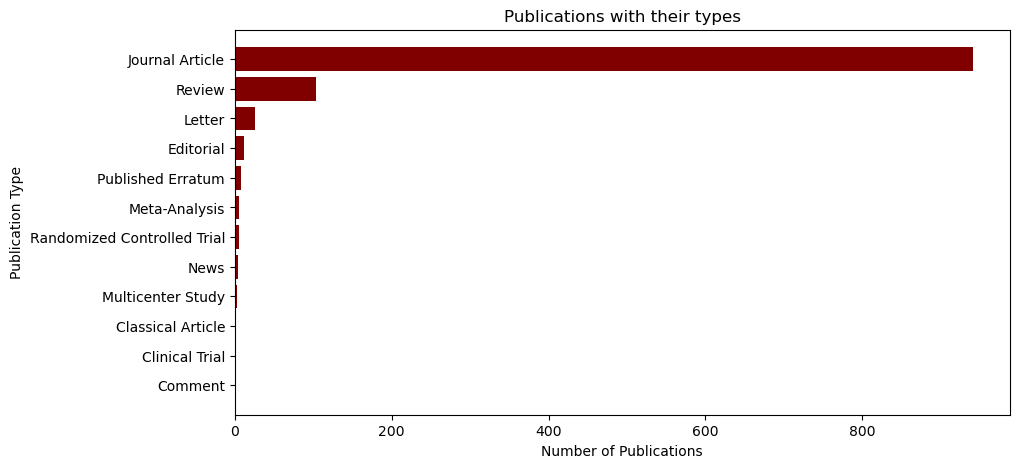

In [9]:
import matplotlib.pyplot as plt

unique_pub_type_dic = {}

for idx, row in df.iterrows():
    x = row["publication_type"]
    for i in x:
        if i in unique_pub_type_dic:
            unique_pub_type_dic[i] +=1
        else:
            unique_pub_type_dic[i] =1
unique_pub_type_dic


x=[]
y=[]
for k,v in sorted(unique_pub_type_dic.items(),key=lambda item: item[1]):
    x.append(k)
    y.append(v)
    
print(x)
print(y)

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.barh(x, y, color ='maroon')
 
plt.ylabel("Publication Type")
plt.xlabel("Number of Publications")
plt.title("Publications with their types")
plt.show()

For more information on accessing PubMed via e-utilities, see https://www.ncbi.nlm.nih.gov/books/NBK25500/. 


## Named entity recognition

We will use the PubTator tool for the given publications to retrieve six types of named entities for the publications (Disease, Gene, Chemical, Species, CellLine, Mutation). To learn more about PubTator, see https://www.ncbi.nlm.nih.gov/research/pubtator/. We access PubTator through its API, which is similar to e-utilities. Note that PubTator does not perform named entity recognition on the fly, but rather retrieves pre-processed results for publications that we specify. 

In [10]:
# BioC is a format that PubTator uses
Format = "biocjson"


# pubtator-api endpoint to fetch details for given PMIDs
r = requests.post("https://www.ncbi.nlm.nih.gov/research/pubtator-api/publications/export/"+Format , json = pmid_json)

if r.status_code != 200 :
    print ("[Error]: HTTP code "+ str(r.status_code))
else:
    pass
   
# Save PubTator results in a JSON file
with open("api_response.json", 'w', encoding='utf8') as outputfile:
    outputfile.write(r.text)
outputfile.close()

In [11]:
# Read PubTator JSON file
with open("api_response.json", encoding='utf-8-sig') as fp:
    response = fp.read()
    response = response.replace('\n', '')
    response = response.replace('}{', '},{')
    response = "[" + response + "]"
    data = json.loads(response)

print(data[0])

{'_id': '38007686|None', 'id': '38007686', 'infons': {}, 'passages': [{'infons': {'journal': 'Cell Rep;2023Oct27; 42 (11) 113292. doi:10.1016/j.celrep.2023.113292', 'year': '2023', 'type': 'title', 'authors': 'Deng Y, Atyeo C, Yuan D, Chicz TM, Tibbitts T, Gorman M, Taylor S, Lecouturier V, Lauffenburger DA, Chicz RM, Alter G, McNamara RP, ', 'section': 'Title'}, 'offset': 0, 'text': 'Beta-spike-containing boosters induce robust and functional antibody responses to SARS-CoV-2 in macaques primed with distinct vaccines.', 'sentences': [], 'annotations': [{'id': '1', 'infons': {'identifier': '2697049', 'type': 'Species'}, 'text': 'SARS-CoV-2', 'locations': [{'offset': 82, 'length': 10}]}], 'relations': []}, {'infons': {'type': 'abstract', 'section': 'Abstract'}, 'offset': 136, 'text': 'The reduced effectiveness of COVID-19 vaccines due to the emergence of variants of concern (VOCs) necessitated the use of vaccine boosters to bolster protection against disease. However, it remains unclear 

Create a dataframe from this retrieved data segregating the fields that we need for our analysis.

In [12]:
data_df = pd.DataFrame(columns = ["id", "authors", "year", "tags", "journal", "created_date", "accessions", "title", "abstract"])

for i in range(len(data)):
    data_df.at[i,"id"] = data[i]["id"]
    data_df.at[i,"authors"] = data[i]["authors"]
    data_df.at[i,"year"] = data[i]["year"]
    try:
        data_df.at[i,"tags"] = data[i]["tags"]
    except: 
        data_df.at[i,"tags"] = []
    data_df.at[i,"journal"] = data[i]["journal"]
    data_df.at[i,"created_date"] = data[i]["created"]["$date"]
    data_df.at[i,"title"] = data[i]["passages"][0]["text"]
    data_df.at[i,"abstract"] = data[i]["passages"][1]["text"]
    typelist = [x.split('@')[0] for x in data[i]["accessions"]]
    data_df.at[i,"accessions"] = set(typelist)
    
data_df.head()


,id,authors,year,tags,journal,created_date,accessions,title,abstract
0,38007686,"[Deng Y, Atyeo C, Yuan D, Chicz TM, Tibbitts T...",2023,[LitCovid],Cell Rep,1701105953283,"{species, disease}",Beta-spike-containing boosters induce robust a...,The reduced effectiveness of COVID-19 vaccines...
1,38007683,"[Bai Y, He F, Yu Y, Li J]",2023,[LitCovid],Technol Health Care,1701105953283,"{species, disease, chemical}",Application of prone position ventilation in v...,BACKGROUND: Patients with coronavirus disease ...
2,38007673,"[Duncan RP, Earhart GM]",2023,[LitCovid],J Parkinsons Dis,1701105953283,{disease},Remote Delivery of Allied Health Therapies in ...,Remote delivery of allied health therapies has...
3,38007667,"[Zhang X, Wu P, Zhao Y]",2023,[LitCovid],J Alzheimers Dis,1701105953283,{disease},COVID-19 in Relation to Alzheimer's Disease: M...,The potential link between COVID-19 and Alzhei...
4,38007657,"[Ding P, Gurney M, Perry G, Xu R]",2023,[LitCovid],J Alzheimers Dis,1701105953283,"{gene, species, disease}",Association of COVID-19 with Risk and Progress...,BACKGROUND: Epidemiological studies showed tha...


We now analyze the entities mentioned in these publications. Note that PubTator performs both named entity recognition and entity linking, linking mentions to relevant knowledge bases like Medical Subject Headings (MeSH) and NCBI Taxonomy. 


First, we will only look at entity types. PubTator identifies 6 types of entities (Disease, Gene, Chemical, Species, Mutation, Cell Line). 

('mutation', 'cellline', 'gene', 'chemical', 'species', 'disease')
(6, 7, 83, 164, 493, 586)


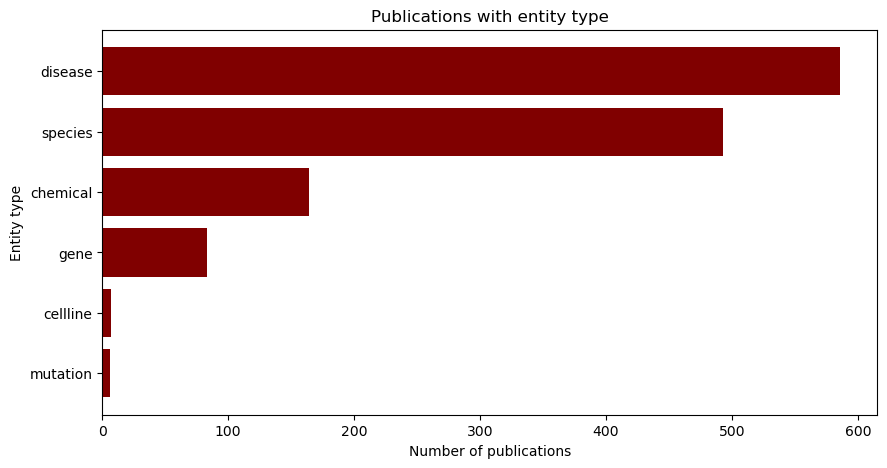

In [13]:
import matplotlib.pyplot as plt

unique_entity_dic = {}

for idx, row in data_df.iterrows():
    x = row["accessions"]
    for i in x:
        if i in unique_entity_dic:
            unique_entity_dic[i] +=1
        else:
            unique_entity_dic[i] =1

x, y = zip(*sorted(unique_entity_dic.items(), key=lambda item: item[1]))
print(x)
print(y)

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.barh(x, y, color ='maroon')
 
plt.ylabel("Entity type")
plt.xlabel("Number of publications")
plt.title("Publications with entity type")
plt.show()

Using this data, we will now find the annotations of different entities that are referenced in these papers.

In [14]:
for item in unique_entity_dic:
    data_df[""+str(item)] = ""
    
data_df.head()

,id,authors,year,tags,journal,created_date,accessions,title,abstract,species,disease,chemical,gene,cellline,mutation
0,38007686,"[Deng Y, Atyeo C, Yuan D, Chicz TM, Tibbitts T...",2023,[LitCovid],Cell Rep,1701105953283,"{species, disease}",Beta-spike-containing boosters induce robust a...,The reduced effectiveness of COVID-19 vaccines...,,,,,,
1,38007683,"[Bai Y, He F, Yu Y, Li J]",2023,[LitCovid],Technol Health Care,1701105953283,"{species, disease, chemical}",Application of prone position ventilation in v...,BACKGROUND: Patients with coronavirus disease ...,,,,,,
2,38007673,"[Duncan RP, Earhart GM]",2023,[LitCovid],J Parkinsons Dis,1701105953283,{disease},Remote Delivery of Allied Health Therapies in ...,Remote delivery of allied health therapies has...,,,,,,
3,38007667,"[Zhang X, Wu P, Zhao Y]",2023,[LitCovid],J Alzheimers Dis,1701105953283,{disease},COVID-19 in Relation to Alzheimer's Disease: M...,The potential link between COVID-19 and Alzhei...,,,,,,
4,38007657,"[Ding P, Gurney M, Perry G, Xu R]",2023,[LitCovid],J Alzheimers Dis,1701105953283,"{gene, species, disease}",Association of COVID-19 with Risk and Progress...,BACKGROUND: Epidemiological studies showed tha...,,,,,,


In [15]:
# keep track of frequency in the dataset
global_diseases = {}
global_chemicals = {}
global_species = {}
global_genes = {}
global_mutations = {}
global_celllines = {}
global_diseases_count = {}
global_chemicals_count = {}
global_species_count = {}
global_genes_count = {}
global_mutations_count = {}
global_celllines_count = {}

for i in range(len(data)):
    ll = data[i]["passages"][1]["annotations"]
    
    diseases = []
    for it in ll:
        if(it["infons"]["type"]=="Disease"):
            name = it["text"]
            identity = it["infons"]["identifier"]
            diseases.append(name)
            
            if identity in global_diseases:
                global_diseases[identity].add(name)
            else:
                global_diseases[identity] = {name}
            
            if identity in global_diseases_count:
                global_diseases_count[identity] +=1
            else:
                global_diseases_count[identity] = 1
                
            diseases = list(set(diseases))
    data_df.at[i,"disease"] = diseases
    
    species = []
    for it in ll:
        if(it["infons"]["type"]=="Species"):
            name = it["text"]
            identity = it["infons"]["identifier"]
            species.append(name)
            
            if identity in global_species:
                global_species[identity].add(name)
            else:
                global_species[identity] = {name}
                
            if identity in global_species_count:
                global_species_count[identity] +=1
            else:
                global_species_count[identity] = 1
                
            species = list(set(species))
    data_df.at[i,"species"] = species
    
    genes = []
    for it in ll:
        if(it["infons"]["type"]=="Gene"):
            name = it["text"]
            identity = it["infons"]["identifier"]
            genes.append(name)
            
            if identity in global_genes:
                global_genes[identity].add(name)
            else:
                global_genes[identity] = {name}
                
            if identity in global_genes_count:
                global_genes_count[identity] +=1
            else:
                global_genes_count[identity] = 1
                
            genes = list(set(genes))
    data_df.at[i,"gene"] = genes
    
    chemicals = []
    for it in ll:
        if(it["infons"]["type"]=="Chemical"):
            name = it["text"]
            identity = it["infons"]["identifier"]
            chemicals.append(name)
            
            if identity in global_chemicals:
                global_chemicals[identity].add(name)
            else:
                global_chemicals[identity] = {name}
                
            if identity in global_chemicals_count:
                global_chemicals_count[identity] +=1
            else:
                global_chemicals_count[identity] = 1
                
            chemicals = list(set(chemicals))
    data_df.at[i,"chemical"] = chemicals
    
    mutations = []
    for it in ll:
        if(it["infons"]["type"]=="Mutation"):
            name = it["text"]
            identity = it["infons"]["identifier"]
            mutations.append(name)
            
            if identity in global_mutations:
                global_mutations[identity].add(name)
            else:
                global_mutations[identity] = {name}
                
            if identity in global_mutations_count:
                global_mutations_count[identity] +=1
            else:
                global_mutations_count[identity] = 1
                
            mutations = list(set(mutations))
    data_df.at[i,"mutation"] = mutations
    
    celllines = []
    for it in ll:
        if(it["infons"]["type"]=="Cellline"):
            name = it["text"]
            identity = it["infons"]["identifier"]
            celllines.append(name)
            
            if identity in global_celllines:
                global_celllines[identity].add(name)
            else:
                global_celllines[identity] = {name}
                
            if identity in global_celllines_count:
                global_celllines_count[identity] +=1
            else:
                global_celllines_count[identity] = 1
                
            celllines = list(set(celllines))
    data_df.at[i,"cellline"] = celllines
    
data_df.head()

,id,authors,year,tags,journal,created_date,accessions,title,abstract,species,disease,chemical,gene,cellline,mutation
0,38007686,"[Deng Y, Atyeo C, Yuan D, Chicz TM, Tibbitts T...",2023,[LitCovid],Cell Rep,1701105953283,"{species, disease}",Beta-spike-containing boosters induce robust a...,The reduced effectiveness of COVID-19 vaccines...,[severe acute respiratory syndrome coronavirus...,[COVID-19],[],[],[],[]
1,38007683,"[Bai Y, He F, Yu Y, Li J]",2023,[LitCovid],Technol Health Care,1701105953283,"{species, disease, chemical}",Application of prone position ventilation in v...,BACKGROUND: Patients with coronavirus disease ...,"[patients, Patients]","[coronavirus disease 2019, COVID-19, acute res...","[PaO2, PPV]",[],[],[]
2,38007673,"[Duncan RP, Earhart GM]",2023,[LitCovid],J Parkinsons Dis,1701105953283,{disease},Remote Delivery of Allied Health Therapies in ...,Remote delivery of allied health therapies has...,[],[COVID-19],[],[],[],[]
3,38007667,"[Zhang X, Wu P, Zhao Y]",2023,[LitCovid],J Alzheimers Dis,1701105953283,{disease},COVID-19 in Relation to Alzheimer's Disease: M...,The potential link between COVID-19 and Alzhei...,[],"[AD, COVID-19, cognitive deficit, Alzheimer's ...",[],[],[],[]
4,38007657,"[Ding P, Gurney M, Perry G, Xu R]",2023,[LitCovid],J Alzheimers Dis,1701105953283,"{gene, species, disease}",Association of COVID-19 with Risk and Progress...,BACKGROUND: Epidemiological studies showed tha...,[participants],"[AD, COVID-19, Alzheimer's disease]",[],[amyloid beta],[],[]


In [16]:
global_diseases_identifiers = sorted(global_diseases, key=lambda k: len(global_diseases[k]), reverse=True)
global_chemicals_identifiers = sorted(global_chemicals, key=lambda k: len(global_chemicals[k]), reverse=True)
global_genes_identifiers = sorted(global_genes, key=lambda k: len(global_genes[k]), reverse=True)

global_diseases_identifiers

['MESH:C000657245',
 None,
 'MESH:D007239',
 'MESH:D000275',
 'MESH:D012141',
 'MESH:D003141',
 'MESH:D009369',
 'MESH:D001007',
 'MESH:D001523',
 'MESH:D003072',
 'MESH:D014947',
 'MESH:D003643',
 'MESH:D060085',
 'MESH:D012128',
 'MESH:D007249',
 'MESH:D005221',
 'MESH:D002908',
 'MESH:D059390',
 'MESH:D007319',
 'MESH:D016638',
 'MESH:D012140',
 'MESH:D064420',
 'MESH:D002318',
 'MESH:D009422',
 'MESH:D058186',
 'MESH:D051271',
 'MESH:D004342',
 'MESH:D003920',
 'MESH:D000544',
 'MESH:D000079225',
 'MESH:D012893',
 'MESH:D006470',
 'MESH:D018352',
 'MESH:D003371',
 'MESH:D001424',
 'MESH:D029424',
 'MESH:D018805',
 'MESH:D001102',
 'MESH:D009765',
 'MESH:D004417',
 'MESH:D005234',
 'MESH:D006973',
 'MESH:D056486',
 'MESH:D006528',
 'MESH:D054556',
 'MESH:D008231',
 'MESH:D012409',
 'MESH:D000857',
 'MESH:D012640',
 'MESH:D006323',
 'MESH:D001943',
 'MESH:D001778',
 'MESH:D004827',
 'MESH:D020271',
 'MESH:D005597',
 'MESH:D009102',
 'MESH:D062787',
 'MESH:D043183',
 'MESH:D020388',
 

In [17]:
diseases_count = {} 
chemicals_count = {}
genes_count = {}

for idx, row in data_df.iterrows():
    x = row["disease"]
    for i in x:
        if i in diseases_count:
            diseases_count[i] +=1
        else:
            diseases_count[i] =1

for idx, row in data_df.iterrows():
    x = row["chemical"]
    for i in x:
        if i in chemicals_count:
            chemicals_count[i] +=1
        else:
            chemicals_count[i] =1

for idx, row in data_df.iterrows():
    x = row["gene"]
    for i in x:
        if i in genes_count:
            genes_count[i] +=1
        else:
            genes_count[i] =1



### Analyzing different entities in these publications

We will visualize the diseases most commonly mentioned in these publications. 

In [ ]:
x = []
y = []
for i in range(20):
    identity = global_diseases_identifiers[i]
    name_list = global_diseases[identity]
    maxx = -1
    name = ""
    for l in name_list:
        if diseases_count[l] > maxx:
            maxx = diseases_count[l]
            name = l
        maxx = max(maxx, diseases_count[l])
    
    x.append(str(identity)+ " - "+ name)
    y.append(global_diseases_count[identity])

dis_dict = {x[i]: y[i] for i in range(len(x))}
x, y = zip(*sorted(dis_dict.items(), key=lambda item: item[1]))

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.barh(x, y, color ='maroon')

plt.ylabel("Disease name and ID")
plt.xlabel("Number of publications")
plt.title("Most frequent diseases in the publications")
plt.show()

Chemicals (including drugs) most commonly mentioned in these publications.

In [ ]:
x = []
y = []
for i in range(20):
    identity = global_chemicals_identifiers[i]
    name_list = global_chemicals[identity]
    maxx = -1
    name = ""
    for l in name_list:
        if chemicals_count[l] > maxx:
            maxx = chemicals_count[l]
            name = l
        maxx = max(maxx, chemicals_count[l])
    
    x.append(str(identity)+ " - "+ name)
    y.append(global_chemicals_count[identity])

chem_dict = {x[i]: y[i] for i in range(len(x))}
x, y = zip(*sorted(chem_dict.items(), key=lambda item: item[1]))

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.barh(x, y, color ='maroon')

plt.ylabel("Chemical")
plt.xlabel("Number of publications")
plt.title("Most frequent chemicals in the publications")
plt.show()

Genes most commonly mentioned in these publications.

In [ ]:
x = []
y = []
for i in range(20):
    identity = global_genes_identifiers[i]
    name_list = global_genes[identity]
    maxx = -1
    name = ""
    for l in name_list:
        if genes_count[l] > maxx:
            maxx = genes_count[l]
            name = l
        maxx = max(maxx, genes_count[l])
    
    x.append(str(identity)+ " - "+ name)
    y.append(global_genes_count[identity])

gene_dict = {x[i]: y[i] for i in range(len(x))}
x, y = zip(*sorted(gene_dict.items(), key=lambda item: item[1]))

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.barh(x, y, color ='maroon')

plt.ylabel("Genes")
plt.xlabel("Number of publications")
plt.title("Most frequent genes in the publications")
plt.show()

You can do the same with other entity types (species, mutations, etc.). 

While PubTator currently does not extract relations, it could be interesting to look at the co-occurrence of different entities in the sentences of these publications as well, which is a very rudimentary way of doing relation extraction. Think about how you might implement this using PubTator entities. 